## Plot generation

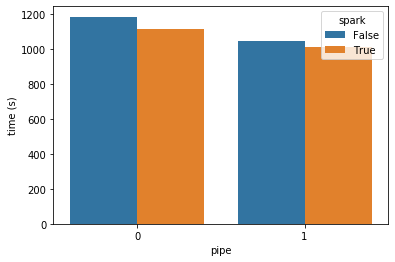

In [5]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(columns = ['time','pipe','spark'])
df = df.append({'time (s)': 19 * 60 + 42.754, 'pipe': 0, 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 17 * 60 + 21.652, 'pipe': 1, 'spark': False}, ignore_index=True)
# df = df.append({'time': 1.169, 'pipe': 3, 'spark': False}, ignore_index=True)
# df = df.append({'time': 1.504, 'pipe': 5, 'spark': False}, ignore_index=True)

df = df.append({'time (s)': 18 * 60 + 35.265, 'pipe': 0, 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 16 * 60 + 50.626, 'pipe': 1, 'spark': True}, ignore_index=True)
# df = df.append({'time': 1.774, 'pipe': 3, 'spark': True}, ignore_index=True)
# df = df.append({'time': 1.377, 'pipe': 5, 'spark': True}, ignore_index=True)

ax = sns.barplot(x="pipe", y="time (s)", hue="spark", data=df)



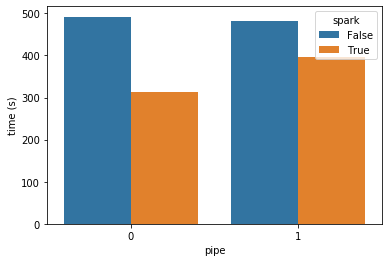

In [7]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(columns = ['time','pipe','spark'])
df = df.append({'time (s)': 8 * 60 + 12.095, 'pipe': 0, 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 8 * 60 + 1.179, 'pipe': 1, 'spark': False}, ignore_index=True)
# df = df.append({'time': 1.169, 'pipe': 3, 'spark': False}, ignore_index=True)
# df = df.append({'time': 1.504, 'pipe': 5, 'spark': False}, ignore_index=True)

df = df.append({'time (s)': 5 * 60 + 13.108, 'pipe': 0, 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 6 * 60 + 37.043, 'pipe': 1, 'spark': True}, ignore_index=True)
# df = df.append({'time': 1.774, 'pipe': 3, 'spark': True}, ignore_index=True)
# df = df.append({'time': 1.377, 'pipe': 5, 'spark': True}, ignore_index=True)

ax = sns.barplot(x="pipe", y="time (s)", hue="spark", data=df)